In [92]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import time
import matplotlib.pyplot as plt
from ast import literal_eval

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [93]:
#gdf = aup.gdf_from_db("mpos_2020", "marco")
mpos = ['02003','02004','02005']
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM hexgrid.hex_grid WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
mun_gdf.head(1)

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,02003,02,003,Tecate,"POLYGON ((-116.68319 32.57160, -116.66266 32.5..."


<AxesSubplot:>

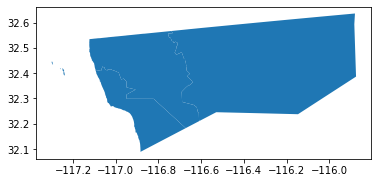

In [94]:
mun_gdf.plot()

In [4]:
poly = mun_gdf.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [5]:
# Downloads OSMnx graph from bounding box
G = ox.graph_from_bbox(n, s, e, w, network_type="all")

In [6]:
nodes_G, edges_G = ox.graph_to_gdfs(G)

In [7]:
print(nodes_G.shape)
nodes_G.head(2)

(123151, 6)


,y,x,street_count,highway,ref,geometry
osmid,,,,,,
103725481,32.359790,-117.055811,3,NaN,NaN,POINT (-117.05581 32.35979)
103725486,32.323418,-117.049000,3,NaN,NaN,POINT (-117.04900 32.32342)


<AxesSubplot:>

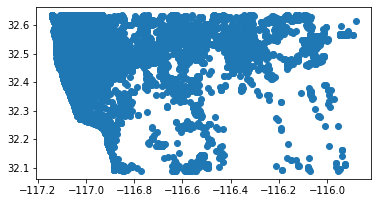

In [8]:
nodes_G.plot()

In [9]:
print(edges_G.shape)
edges_G.head(2)

(311372, 16)


osmid  oneway lanes   highway  \
u         v          key                                                   
103725481 6210860903 0    [673038537, 691638293]    True     1  tertiary   
          6217546652 0                 754118390    True     2  motorway   

                           length                        name  \
u         v          key                                        
103725481 6210860903 0    185.672              Calle Ensenada   
          6217546652 0    758.957  Autopista Tijuana-Ensenada   

                                                                   geometry  \
u         v          key                                                      
103725481 6210860903 0    LINESTRING (-117.05581 32.35979, -117.05584 32...   
          6217546652 0    LINESTRING (-117.05581 32.35979, -117.05555 32...   

                             ref maxspeed bridge service junction access  \
u         v          key                                                   
103725481 6210860903 0       NaN      NaN    NaN     NaN      NaN    NaN   
          6217546652 0    MEX 1D      NaN    NaN     NaN      NaN    NaN   

                         tunnel width area  
u         v          key                    
103725481 6210860903 0      NaN   NaN  NaN  
          6217546652 0      NaN   NaN  NaN

<AxesSubplot:>

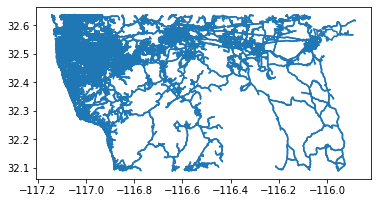

In [10]:
edges_G.plot()

In [11]:
query = f"SELECT * FROM osmnx_new.nodes WHERE (\"x\" between \'{w}\' and \'{e}\') and (\"y\" between \'{s}\' and \'{n}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(124562, 5)


,osmid,x,y,street_count,geometry
0,2880764845,-116.855909,32.092665,1,POINT (-116.85591 32.09267)
1,103725481,-117.055811,32.359790,3,POINT (-117.05581 32.35979)


<AxesSubplot:>

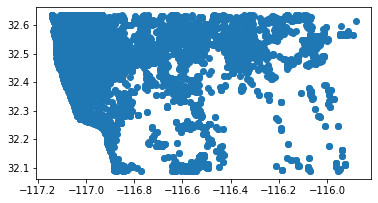

In [12]:
nodes.plot()

In [13]:
nodes_G2 = nodes_G.reset_index()[['osmid','x','y','street_count','geometry']]
nodes_dif = nodes_G2.merge(nodes, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
#nodes_dif = pd.concat([nodes,nodes_G2]).drop_duplicates(keep=False)
nodes_dif

,osmid,x,y,street_count,geometry,_merge
6651,7174839616,-116.889987,32.142596,1,POINT (-116.88999 32.14260),left_only
8419,48870864,-117.114475,32.543351,3,POINT (-117.11448 32.54335),left_only
8512,48906829,-117.109991,32.543389,3,POINT (-117.10999 32.54339),left_only
8823,49044722,-117.106600,32.542209,1,POINT (-117.10660 32.54221),left_only
8824,49044727,-117.106044,32.541715,1,POINT (-117.10604 32.54172),left_only
...,...,...,...,...,...,...
119765,8964024850,-116.630540,32.570283,4,POINT (-116.63054 32.57028),left_only
119766,8964024852,-116.628919,32.570464,1,POINT (-116.62892 32.57046),left_only
119767,8964024985,-116.630166,32.571359,3,POINT (-116.63017 32.57136),left_only
119768,8964024986,-116.630122,32.571036,1,POINT (-116.63012 32.57104),left_only


In [14]:
poly_wkt = f"POLYGON(({w} {s}, {w} {n}, {e} {n}, {e} {s}, {w} {s}))"
poly_wkt

'POLYGON((-117.30044937129796 32.08832854965278, -117.30044937129796 32.63608123025133, -115.87420488989801 32.63608123025133, -115.87420488989801 32.08832854965278, -117.30044937129796 32.08832854965278))'

In [15]:
query = f"SELECT * FROM osmnx_new.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(query, geometry_col='geometry')
print(edges.shape)
edges.head(2)

(315633, 18)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,761830297,6428827568,5259721722,0,False,None,None,residential,None,129.165,"LINESTRING (-116.98843 32.33647, -116.98829 32...",None,None,None,None,None,None,None
1,761831393,6421094210,5259721728,0,False,None,None,residential,None,238.120,"LINESTRING (-116.99075 32.33641, -116.99072 32...",None,None,None,None,None,None,None


<AxesSubplot:>

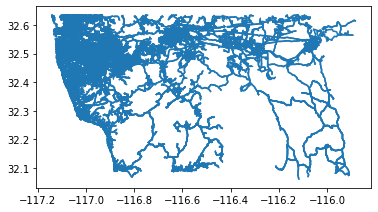

In [16]:
edges.plot()

In [72]:
edges_G2 = edges_G.reset_index()[['u','v','key','osmid','length','name','geometry']]
edges_G2['name'] = edges_G2['name'].astype("str")
edges_G2.osmid = edges_G2.osmid.apply(lambda x: tuple(x) if type(x) == list else x)
edges_tmp = edges.copy()
edges_tmp.osmid = edges_tmp.osmid.apply(literal_eval)
edges_tmp.osmid = edges_tmp.osmid.apply(lambda x: tuple(x) if type(x) == list else x)
#edges.osmid = edges.osmid.apply(lambda x: tuple(x) if type(x) == list else x)
edges_dif = edges_G2.merge(edges_tmp, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
edges_dif

,u,v,key,osmid,length,name,geometry,oneway,lanes,highway,maxspeed,bridge,ref,junction,tunnel,access,width,service,_merge
3,103725521,3203889267,0,14306226,152.379,nan,"LINESTRING (-116.92051 32.22869, -116.92029 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
17,122608887,6487755506,0,"(762081048, 13286514)",301.133,"['Calle Paseo de las Pelícanos Oeste', 'Paseo ...","LINESTRING (-116.96599 32.25424, -116.96621 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
31,122615747,6409404977,0,693295206,1240.957,nan,"LINESTRING (-116.92364 32.23665, -116.92338 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,122615751,6508666169,0,"(690223697, 684175019)",390.142,nan,"LINESTRING (-116.92385 32.23630, -116.92391 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47,137458697,137460638,0,14304755,68.028,nan,"LINESTRING (-116.91526 32.22275, -116.91521 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312815,7181801628,7181042649,0,769266608,3563.110,nan,"LINESTRING (-116.20972 32.10490, -116.20996 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
312816,8725313403,8725313374,0,942240883,1728.462,nan,"LINESTRING (-115.99680 32.32355, -115.99644 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
312817,8725313403,7181059729,0,942240883,6937.446,nan,"LINESTRING (-115.99680 32.32355, -115.99740 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
312818,8725313403,7128904651,0,942241384,6378.926,nan,"LINESTRING (-115.99680 32.32355, -115.99702 32...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [76]:
c_edges = len(edges_G)/10000
c_edges

31.1372

In [90]:
c_edges = len(edges_G)/10000
for i in range(int(c_edges)+1):
    edges_upload = edges_G.iloc[int(10000*i):int(10000*(i+1))].copy()
edges_upload

osmid  oneway lanes       highway  \
u          v          key                                                       
7114136494 7114136576 0                 758360250   False     2  unclassified   
           7114136520 0    [758360250, 757056711]   False     2  unclassified   
           7114136500 0                 761436553   False   NaN   residential   
7114136500 7082253381 0                 693740118   False   NaN  unclassified   
           7079592354 0                 693740118   False   NaN  unclassified   
...                                           ...     ...   ...           ...   
7181801628 7181042649 0                 769266608   False   NaN  unclassified   
8725313403 8725313374 0                 942240883   False   NaN         track   
           7181059729 0                 942240883   False   NaN         track   
           7128904651 0                 942241384   False   NaN         track   
           4842327541 0                 942241384   False   NaN         track   

                             length                       name  \
u          v          key                                        
7114136494 7114136576 0     922.530  Camino a la Laguna Hanson   
           7114136520 0     328.493  Camino a la Laguna Hanson   
           7114136500 0     685.477                        NaN   
7114136500 7082253381 0     265.374                        NaN   
           7079592354 0     502.375                        NaN   
...                             ...                        ...   
7181801628 7181042649 0    3563.110                        NaN   
8725313403 8725313374 0    1728.462                        NaN   
           7181059729 0    6937.446                        NaN   
           7128904651 0    6378.926                        NaN   
           4842327541 0    1046.178                        NaN   

                                                                    geometry  \
u          v          key                                                      
7114136494 7114136576 0    LINESTRING (-116.05020 32.48975, -116.05003 32...   
           7114136520 0    LINESTRING (-116.05020 32.48975, -116.05034 32...   
           7114136500 0    LINESTRING (-116.05020 32.48975, -116.05031 32...   
7114136500 7082253381 0    LINESTRING (-116.05649 32.48864, -116.05645 32...   
           7079592354 0    LINESTRING (-116.05649 32.48864, -116.05650 32...   
...                                                                      ...   
7181801628 7181042649 0    LINESTRING (-116.20972 32.10490, -116.20996 32...   
8725313403 8725313374 0    LINESTRING (-115.99680 32.32355, -115.99644 32...   
           7181059729 0    LINESTRING (-115.99680 32.32355, -115.99740 32...   
           7128904651 0    LINESTRING (-115.99680 32.32355, -115.99702 32...   
           4842327541 0    LINESTRING (-115.99680 32.32355, -115.99669 32...   

                           ref maxspeed bridge service junction access tunnel  \
u          v          key                                                       
7114136494 7114136576 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7114136520 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7114136500 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
7114136500 7082253381 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7079592354 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
...                        ...      ...    ...     ...      ...    ...    ...   
7181801628 7181042649 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
8725313403 8725313374 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7181059729 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7128904651 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           4842327541 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   

                          width area

In [88]:
edges_upload = edges_G.iloc[310000:320000].copy()
edges_upload

osmid  oneway lanes       highway  \
u          v          key                                                       
7114136494 7114136576 0                 758360250   False     2  unclassified   
           7114136520 0    [758360250, 757056711]   False     2  unclassified   
           7114136500 0                 761436553   False   NaN   residential   
7114136500 7082253381 0                 693740118   False   NaN  unclassified   
           7079592354 0                 693740118   False   NaN  unclassified   
...                                           ...     ...   ...           ...   
7181801628 7181042649 0                 769266608   False   NaN  unclassified   
8725313403 8725313374 0                 942240883   False   NaN         track   
           7181059729 0                 942240883   False   NaN         track   
           7128904651 0                 942241384   False   NaN         track   
           4842327541 0                 942241384   False   NaN         track   

                             length                       name  \
u          v          key                                        
7114136494 7114136576 0     922.530  Camino a la Laguna Hanson   
           7114136520 0     328.493  Camino a la Laguna Hanson   
           7114136500 0     685.477                        NaN   
7114136500 7082253381 0     265.374                        NaN   
           7079592354 0     502.375                        NaN   
...                             ...                        ...   
7181801628 7181042649 0    3563.110                        NaN   
8725313403 8725313374 0    1728.462                        NaN   
           7181059729 0    6937.446                        NaN   
           7128904651 0    6378.926                        NaN   
           4842327541 0    1046.178                        NaN   

                                                                    geometry  \
u          v          key                                                      
7114136494 7114136576 0    LINESTRING (-116.05020 32.48975, -116.05003 32...   
           7114136520 0    LINESTRING (-116.05020 32.48975, -116.05034 32...   
           7114136500 0    LINESTRING (-116.05020 32.48975, -116.05031 32...   
7114136500 7082253381 0    LINESTRING (-116.05649 32.48864, -116.05645 32...   
           7079592354 0    LINESTRING (-116.05649 32.48864, -116.05650 32...   
...                                                                      ...   
7181801628 7181042649 0    LINESTRING (-116.20972 32.10490, -116.20996 32...   
8725313403 8725313374 0    LINESTRING (-115.99680 32.32355, -115.99644 32...   
           7181059729 0    LINESTRING (-115.99680 32.32355, -115.99740 32...   
           7128904651 0    LINESTRING (-115.99680 32.32355, -115.99702 32...   
           4842327541 0    LINESTRING (-115.99680 32.32355, -115.99669 32...   

                           ref maxspeed bridge service junction access tunnel  \
u          v          key                                                       
7114136494 7114136576 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7114136520 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7114136500 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
7114136500 7082253381 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7079592354 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
...                        ...      ...    ...     ...      ...    ...    ...   
7181801628 7181042649 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
8725313403 8725313374 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7181059729 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           7128904651 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   
           4842327541 0    NaN      NaN    NaN     NaN      NaN    NaN    NaN   

                          width area

In [89]:
int(10000*c_edges)

311372